# Importing Modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random

# Defining Functions for Multiple Linear Regression

## Functions to Prepare DataFrame

In [15]:
def get_features_targets(df, feature_names, target_names):
    # used to get columns referring to features and target from a DataFrame
    # feature_names and target_names must be lists
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def normalize_z(df):
    # used to normalize features to allow computation of large data while maintaining relation ship with target variable
    data = (df- df.mean())/df.std()
    return data

def polynomial_feature(df, col_name ,n):
    df2 = df.copy()
    k = 2
    while k <= n:
        new_col_name = col_name +'^' + str(k)
        df2.loc[:, new_col_name] = df.loc[:,col_name] ** k 
        k += 1
    return df2

def reciprocal_features(df, col_name, n):
    df2 = pd.DataFrame()
    k = -1
    while k >= n:
        new_col_name = col_name +'^' + str(k)
        df2.loc[:, new_col_name] = 1/ (df.loc[:,col_name] ** (-k)) 
        k -= 1
    return df2

def prepare_feature(df_feature):
    # adds a column of 1's and converts DataFrame to a np array to do matrix operations
    ones = np.ones((df_feature.shape[0],1))
    np_feature = np.concatenate((ones, df_feature), axis = 1)
    return np_feature

def prepare_target(df_target):
    #converts df_target to np array
    return df_target.values

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    #split df_feature, df_target to 2 sets for training and testing
    indexes = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    k = int(test_size * len(indexes))
    test_index = np.random.choice(indexes,k, replace = False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index,:]
    df_target_test = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

## Functions to apply Regression

In [3]:
def compute_cost(X, y, beta):
    # computes the value of cost function (Average mean squared error)
    J = 1/(2* len(X)) * np.sum(np.power(((X @ beta)- y), 2))
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    # carrys out gradient descent to minimize cost function
    J_storage = np.zeros(num_iters)
    for i in range(num_iters):
        beta = beta - (alpha/len(X)) * (X.T @ (X @ beta - y))
        J_storage[i] = compute_cost(X, y, beta)
    return beta, J_storage

## Functions to evaluate model

In [4]:
def predict(df_feature, beta):
    # returns values of target_pred for a given test set of features
    X_df = normalize_z(df_feature)
    X = prepare_feature(X_df)
    return predict_norm(X, beta)

def predict_norm(X, beta):
    # returns values of target_pred for a given test set of normalized features
    return X @ beta

def r2_score(y, ypred):
    #calculates r2_score to determine strength of correlation
    SS_res = np.sum(np.power((y - ypred), 2))
    SS_tot = np.sum(np.power((y - y.mean()), 2))
    return 1- SS_res/SS_tot

def mean_squared_error(target, pred):
    #returns sum of mean squared error
    return np.sum(np.power((target - pred), 2))/len(target)

# Validating Models

## Importing and Cleaning Data

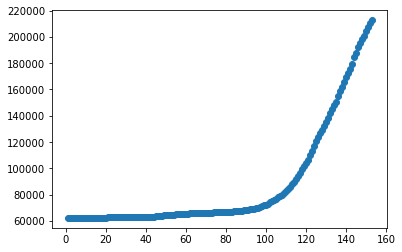

In [38]:
#importing csv
df = pd.read_csv('archive\covid19_sg.csv', parse_dates = ['Date'])

#selecting required data
df_select = df.loc[500:,:]
df_select2 = df_select.copy()
df_select2['days'] = df_select.loc[:,'Date'].apply(lambda x: (x- df_select.iloc[0,0]).days + 1)

# Getting columns corresponding to features and targets
df_feature, df_target = get_features_targets(df_select2, ['days'] ,['Cumulative Confirmed'])
plt.scatter(df_feature['days'], df_target['Cumulative Confirmed'])

## Preparing Features and targets

### Polynomial model

In [65]:
# setting up polynomial features
df_features_p = polynomial_feature(df_feature, 'days', 4)
#splitting test and training data
df_features_p_train, df_features_p_test, df_target_train, df_target_test = split_data(df_features_p, df_target, random_state=100, test_size= 0.3)
#normalising feature
df_features_p_train_z = normalize_z(df_features_p_train)
#preparing features and targets as numpy arrays
X = prepare_feature(df_features_p_train_z)
target = prepare_target(df_target_train)

#### Carrying out Gradient descent

In [67]:
# setting parameters
beta = np.zeros([5,1])
alpha = 0.01
iters = 1000

# calling gradient descent
beta_p, cost = gradient_descent(X, target, beta, alpha, iters)

print(beta_p)

[[ 86237.78610573]
 [-10433.97347481]
 [  4651.59303582]
 [ 17577.35425078]
 [ 27422.4405953 ]]


#### Plotting Cost over iterations

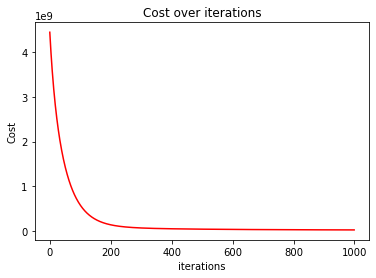

In [68]:
fig, ax = plt.subplots()
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('iterations')
ax.set_ylabel('Cost')
ax.set_title('Cost over iterations')
plt.show()

#### Plotting graph for predicted and actual target values for the test data

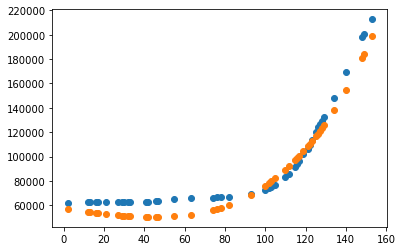

In [74]:
pred = predict(df_features_p_test, beta_p)
plt.scatter(df_features_p_test['days'], df_target_test)
plt.scatter(df_features_p_test['days'], pred)

### Reciprocal model

In [70]:
# setting up polynomial features
df_features_r = reciprocal_features(df_feature, 'days', -3)
#splitting test and training data
df_features_r_train, df_features_r_test, df_target_train, df_target_test = split_data(df_features_r, df_target,
                                                                                        random_state=100, test_size= 0.3)
#normalising feature
df_features_r_train_z = normalize_z(df_features_r_train)
# preparing features and targets as numpy arrays
X = prepare_feature(df_features_r_train_z)
target = prepare_target(df_target_train)

#### Carrying out Gradient descent

In [71]:
# setting parameters
beta = np.zeros([4,1])
alpha = 0.01
iters = 1000

# calling gradient descent
beta_r, cost = gradient_descent(X, target, beta, alpha, iters)

print(beta_r, cost[-1])

[[ 86237.78610573]
 [-19924.06524809]
 [  6626.22111905]
 [  8376.97218619]] 798910782.3161035


#### Plotting Cost over iterations

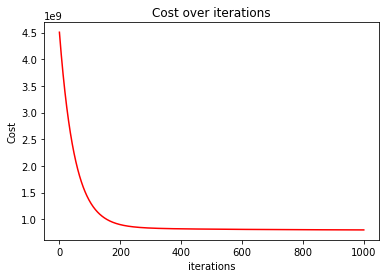

In [72]:
fig, ax = plt.subplots()
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('iterations')
ax.set_ylabel('Cost')
ax.set_title('Cost over iterations')
plt.show()

#### Plotting graph for predicted and actual target values for the test data

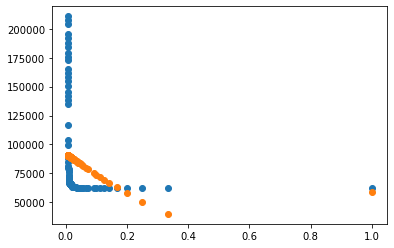

In [73]:
pred = predict(df_features_r_train, beta_r)
plt.scatter(df_features_r_train['days^-1'], df_target_train)
plt.scatter(df_features_r_train['days^-1'], pred)